# 贪婪算法的不同和优化

## 现在将创建不同的 Agent 并统计平均值，后悔值，命中率

In [1]:
from typing import Callable, List, Tuple
import gc

from core import EpsilonDecreasingConfig, GreedyAgent, Rewards, RLEnv
from train import train, AverageMetrics
from algorithms import greedy_average, epsilon_average, epsilon_decreasing_average

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

from pathlib import Path

import json

In [2]:
SEED = 42
env = RLEnv(machine_count=100, seed=SEED)
COUNT = 50
STEPS = 10_000
CONVERGENCE_THRESHOLD = 0.9
CONVERGENCE_MIN_STEPS = 1000
EXPERMENT_DATA_FOLDER = Path.cwd() / "experiment_data"
OPTIMISTIC_TIMES = 0
ENABLE_OPTIMISTIC = False

In [3]:
def batch_train(
    count: int,
    greedy_algorithm: Callable[..., int],
    env: RLEnv,
    epsilon_config: EpsilonDecreasingConfig,
    steps: int,
    optimistic_init: bool,
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> Tuple[List[GreedyAgent], Rewards, AverageMetrics]:
    """批训练 Agent，传入数量，不同的算法，环境，步数和初始种子即可训练

    Args:
        count (int): 训练数量
        agent (GreedyAgent): 算法 类型
        env (RLEnv): 环境
        steps (int): 步数
        seed (int): 初始种子

    Returns:
        Tuple[List[GreedyAgent], Rewards]: 返回训练后的 agents 和平均后的奖励
    """
    _agents: List[GreedyAgent] = []

    if not callable(greedy_algorithm):
        raise ValueError("算法必须传入一个函数")

    for i in range(count):
        _agents.append(
            GreedyAgent(
                name=greedy_algorithm.__name__,  # type: ignore # 在 callable 这里就已经验证了是一个函数，这里是为了避免 ty 工具误报
                env=env,
                greedy_algorithm=greedy_algorithm,
                epsilon_config=epsilon_config,
                optimistic_init=optimistic_init,
                optimistic_times=optimistic_times,
                convergence_threshold=convergence_threshold,
                convergence_min_steps=convergence_min_steps,
                seed=seed + i,
            )
        )

    agents, reward, metrics = train(_agents, steps)

    return agents, reward, metrics


def plot_metrics_history(agents: List[GreedyAgent], agent_name: str, file_name: str):
    """
    根据训练后的一组 agent 的 metrics_history 绘制指标变化图。

    Args:
        agents (List[GreedyAgent]): 经过训练的 agent 列表。
        agent_name (str): 这组 agent 的名称，用于图表标题。
        file_name (str): 保存的文件名（例如："experiment_result.png"）
    """

    if not agents:
        raise ValueError("Agents 列表为空，无法绘图")

    # 1. 设置字体
    font_path = Path.cwd() / "assets" / "微软雅黑.ttf"
    if font_path.exists():
        font_prop = FontProperties(fname=font_path, size=12)
        title_font_prop = FontProperties(fname=font_path, size=16)
        print("成功加载字体：", font_path)

    else:
        print(f"警告：找不到字体文件 {font_path}，将使用默认字体，中文可能显示为方框。")
        font_prop = FontProperties(size=12)
        title_font_prop = FontProperties(size=16)

    # 2. 准备数据
    num_steps: int = agents[0].steps

    avg_history = {
        "regret": np.zeros(num_steps),
        "regret_rate": np.zeros(num_steps),
        "total_reward": np.zeros(num_steps),
        "optimal_rate": np.zeros(num_steps),
        "convergence_steps": np.zeros(num_steps),
        "convergence_rate": np.zeros(num_steps),
    }

    # 遍历每个时间步
    for step_idx in range(num_steps):
        # 临时存储当前时间步所有 agent 的指标
        step_metrics = {
            "regret": [],
            "regret_rate": [],
            "total_reward": [],
            "optimal_rate": [],
            "convergence_steps": [],
            "convergence_rate": [],
        }
        # 遍历每个 agent
        for agent in agents:
            # agent.metrics_history 的索引与 step_idx 一致
            if step_idx < len(agent.metrics_history):
                metrics_at_step = agent.metrics_history[step_idx][
                    1
                ]  # (Rewards, Metrics, int) -> Metrics
                step_metrics["regret"].append(metrics_at_step.regret)
                step_metrics["regret_rate"].append(metrics_at_step.regret_rate)
                step_metrics["total_reward"].append(sum(metrics_at_step.rewards.values))
                step_metrics["optimal_rate"].append(metrics_at_step.optimal_rate)
                step_metrics["convergence_steps"].append(agent.convergence_steps)
                step_metrics["convergence_rate"].append(1 if agent.convergence_steps > 0 else 0)

        # 计算当前时间步的平均值并存入 avg_history
        for key in avg_history:
            if step_metrics[key]:  # 确保列表不为空
                avg_history[key][step_idx] = np.mean(step_metrics[key])

    steps_axis = np.arange(1, num_steps + 1)

    # 3. 开始绘图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=100)
    fig.suptitle(f'"{agent_name}" 算法平均指标变化情况', fontproperties=title_font_prop)

    assert isinstance(axes, np.ndarray)
    axes = axes.flatten()

    plot_config = {
        "regret": "后悔值 (Regret)",
        "regret_rate": "后悔率 (Regret Rate)",
        "total_reward": "累积总奖励 (Total Reward)",
        "optimal_rate": "最优臂选择率 (Optimal Rate)",
        "convergence_steps": "达到收敛时的步数 (Convergence Steps)",
        "convergence_rate": "达到收敛率 (Convergence Rate)",
    }

    for i, (metric_key, title) in enumerate(plot_config.items()):
        ax = axes[i]
        ax.plot(steps_axis, avg_history[metric_key], label=title)
        ax.set_title(title, fontproperties=font_prop)
        ax.set_xlabel("时间步 (Steps)", fontproperties=font_prop)
        ax.set_ylabel("平均值", fontproperties=font_prop)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(prop=font_prop)

    plt.tight_layout(rect=(0, 0, 1, 0.96))
    plt.show()
    
    if not file_name.endswith(".png"):
        file_name += ".png"
    fig.savefig(EXPERMENT_DATA_FOLDER / file_name)
    print(f"✅ 实验数据已保存至 {file_name}")

def save_experiment_data(
    agents: List[GreedyAgent],
    reward: Rewards,
    metrics: AverageMetrics,
    file_name: str
):
    """
    将实验结果保存为 JSON 文件。
    
    Args:
        agents: 训练后的所有 agent 实例列表
        reward: 平均奖励信息
        metrics: 平均评估指标
        file_name: 保存的文件名（例如："experiment_result.json"）
    """
    
    # 转换 Agents 数据为可序列化的字典
    agents_data = []
    for agent in agents:
        agent_history = [
            {
                "step": step,
                "rewards": {
                    "values": list(rewards.values),
                    "counts": list(rewards.counts),
                    "q_values": list(rewards.q_values),
                },
                "metrics": {
                    "regret": m.regret,
                    "regret_rate": m.regret_rate,
                    "optimal_rate": m.optimal_rate,
                }
            }
            for rewards, m, step in agent.metrics_history
        ]
        
        agents_data.append({
            "name": agent.name,
            "seed": agent.seed,
            "steps": agent.steps,
            "convergence_steps": agent.convergence_steps,
            "history": agent_history,
            "final_rewards": {
                "values": list(agent.rewards.values),
                "counts": list(agent.rewards.counts),
                "q_values": list(agent.rewards.q_values),
            },
            "final_metrics": agent.metric().model_dump() if hasattr(agent.metric(), 'model_dump') else vars(agent.metric()),
        })

    # 构造最终输出的 JSON 数据
    experiment_data = {
        "average_reward": {
            "values": list(reward.values),
            "counts": list(reward.counts),
        },
        "average_metrics": {
            "avg_regret": metrics.avg_regret,
            "avg_regret_rate": metrics.avg_regret_rate,
            "avg_total_reward": metrics.avg_total_reward,
            "avg_optimal_rate": metrics.avg_optimal_rate,
            "avg_convergence_steps": metrics.avg_convergence_steps,
            "avg_convergence_rate": metrics.avg_convergence_rate,
        },
        "agents": agents_data,
    }

    # 写入文件
    if not EXPERMENT_DATA_FOLDER.exists():
        EXPERMENT_DATA_FOLDER.mkdir(parents=True, exist_ok=True)
    with open(EXPERMENT_DATA_FOLDER / file_name, "w", encoding="utf-8") as f:
        json.dump(experiment_data, f, ensure_ascii=False, indent=4)

    print(f"✅ 实验数据已保存至 {file_name}")


## 平均奖励

### 普通贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


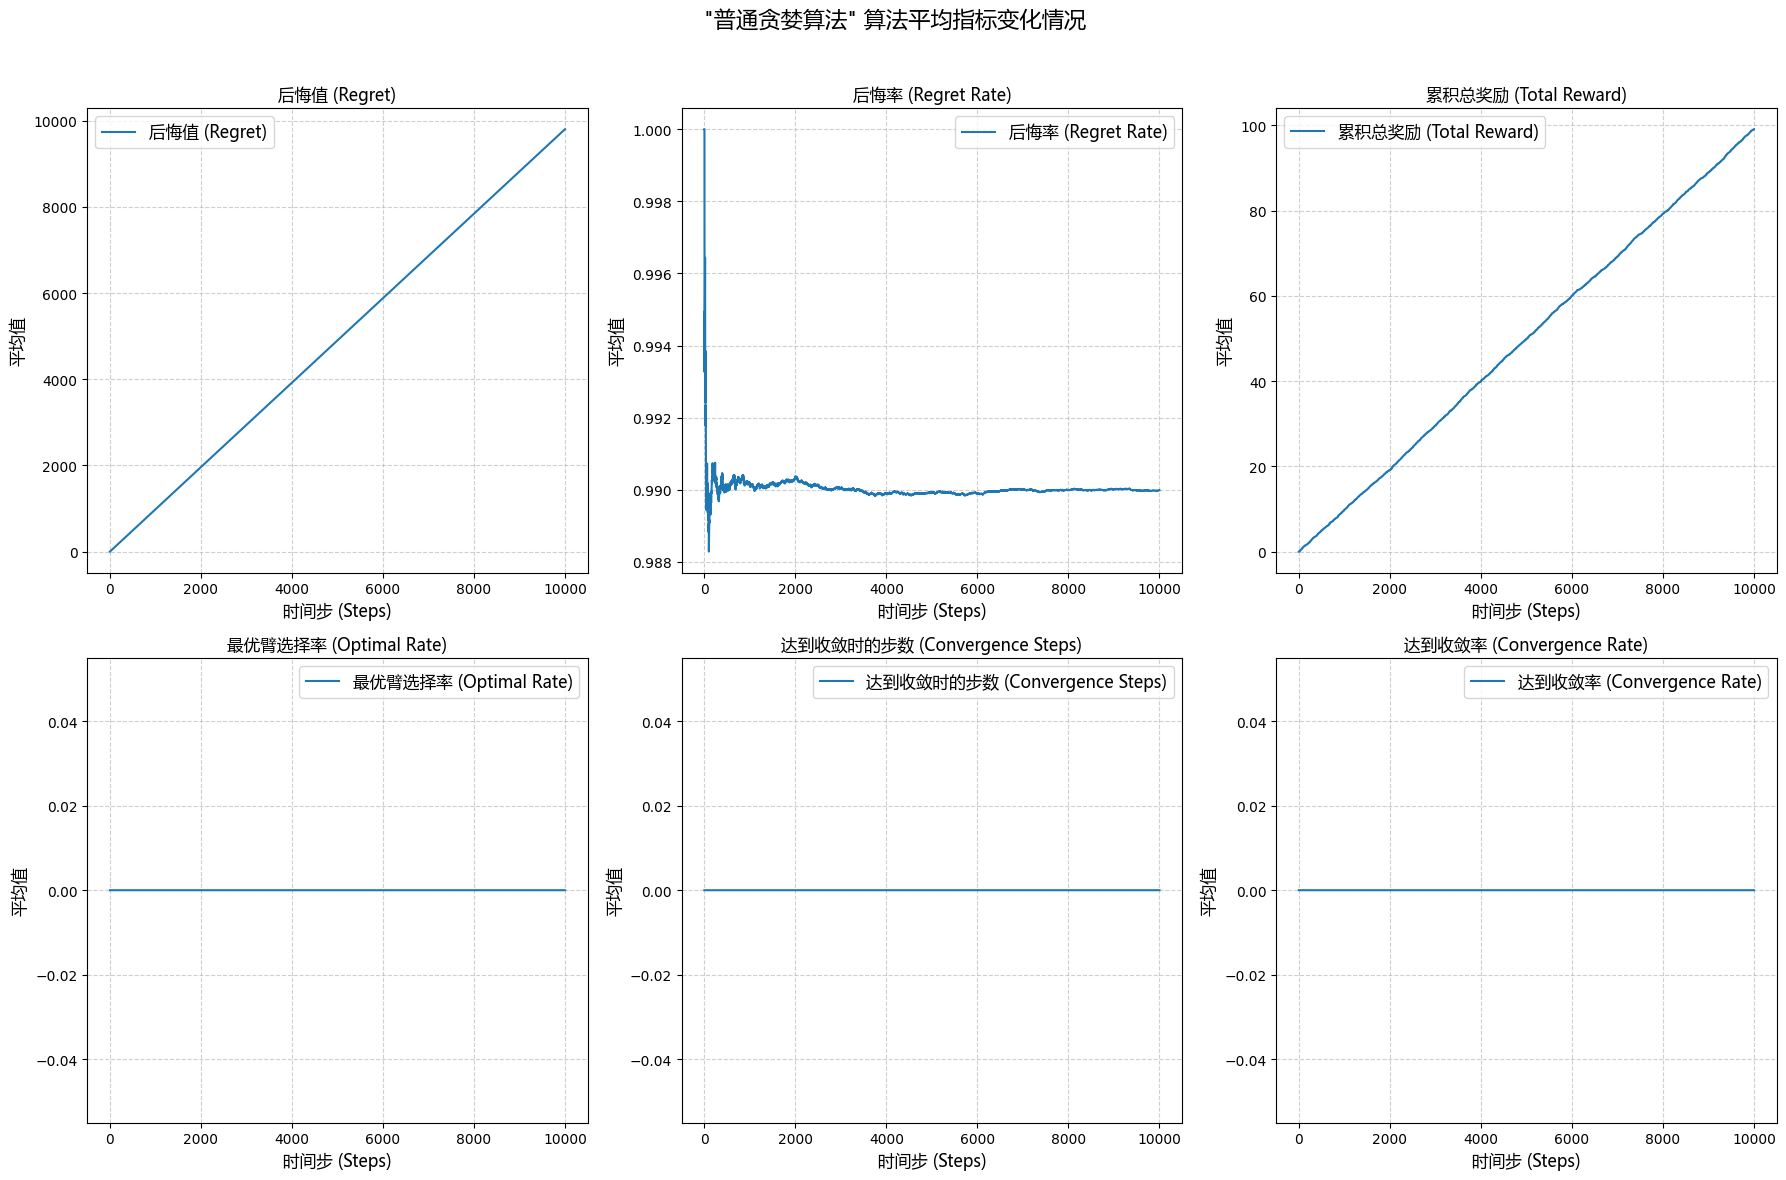

✅ 实验数据已保存至 greedy_average_Q_0=0.png
anget 名称: greedy_average
平均奖励：values=[99.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] counts=[10000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

21515

In [4]:
# 普通贪婪算法的结果
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=greedy_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="普通贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()

### 随机探索贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


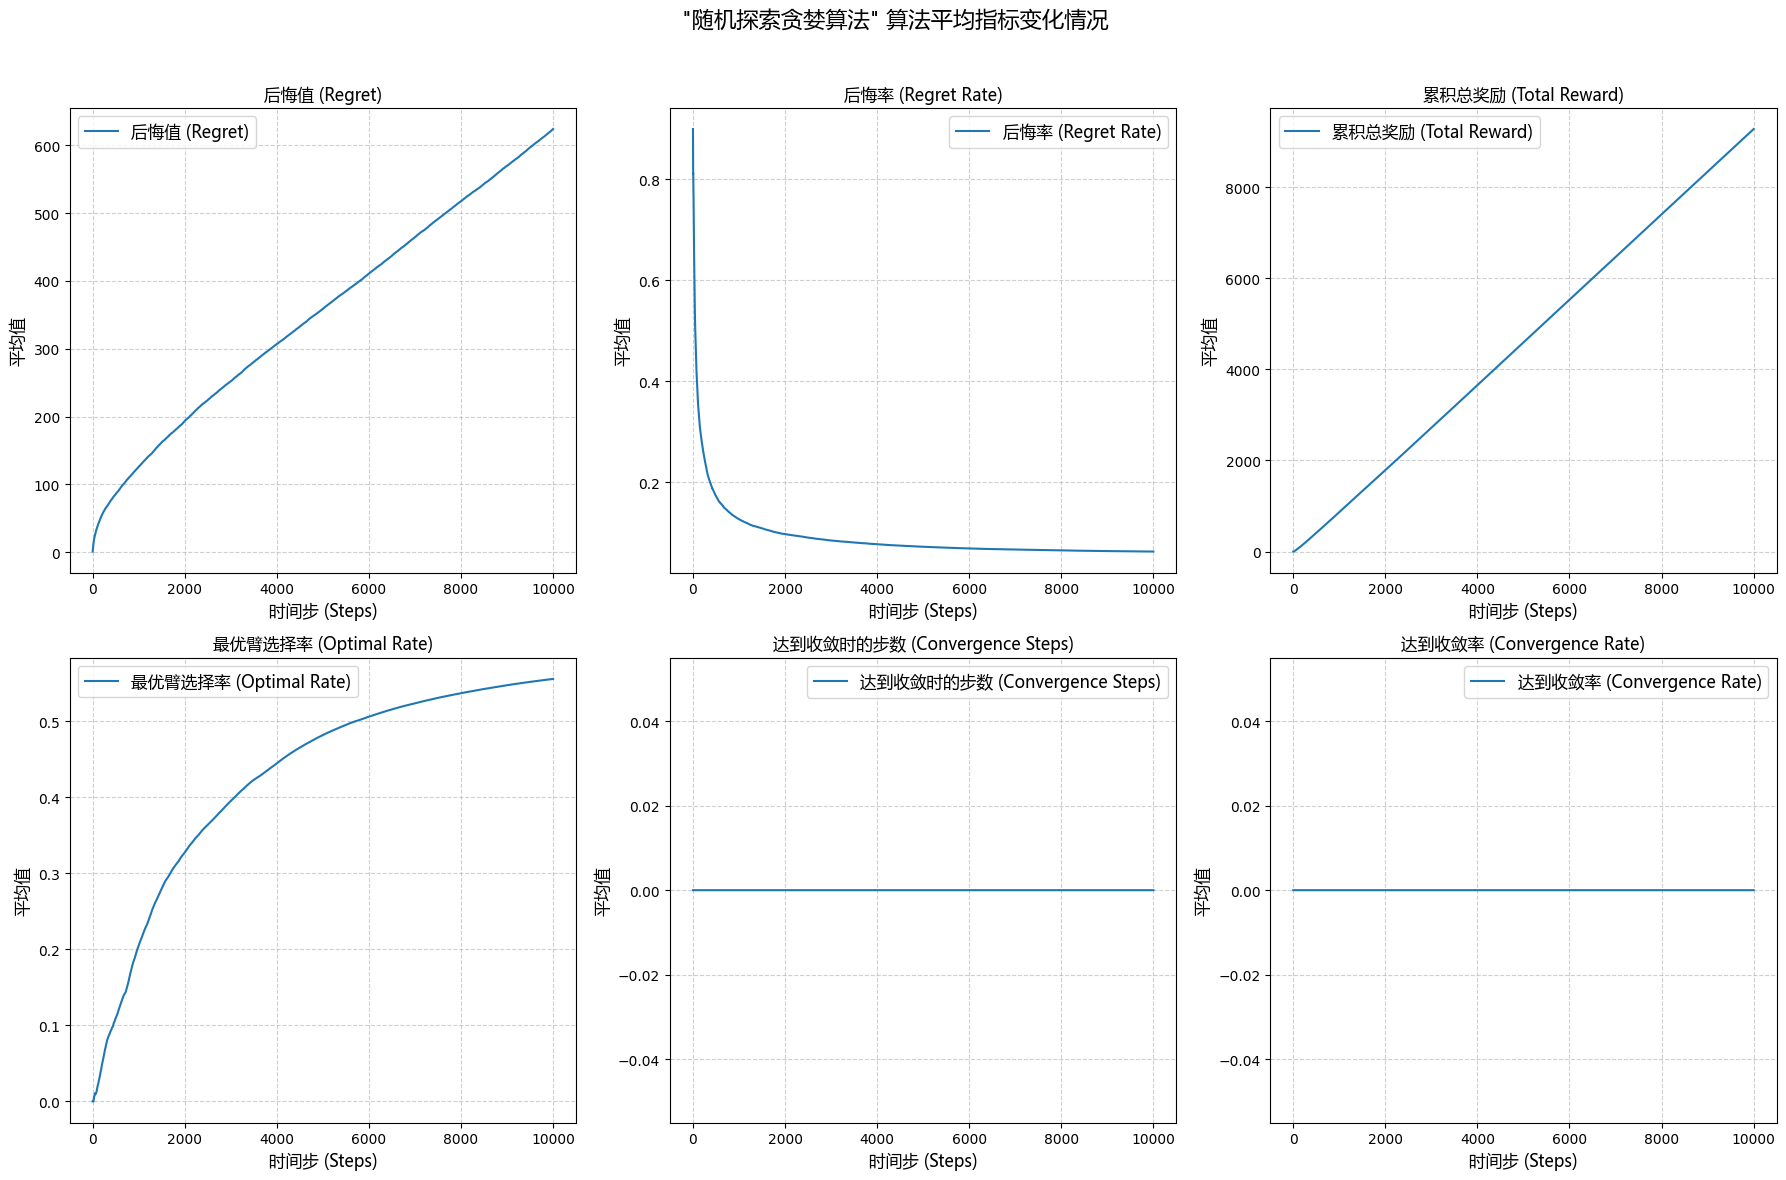

✅ 实验数据已保存至 epsilon_average_Q_0=0.png
anget 名称: epsilon_average
平均奖励：values=[0.38, 0.22, 0.32, 0.42, 0.44, 0.48, 0.6, 0.7, 0.84, 1.02, 1.02, 1.2, 1.28, 1.64, 1.32, 1.52, 1.46, 1.78, 1.92, 1.76, 1.98, 1.98, 2.48, 2.62, 2.6, 2.82, 3.28, 3.26, 3.26, 3.12, 3.5, 3.44, 3.38, 4.16, 4.0, 4.3, 3.76, 3.92, 4.72, 4.52, 4.42, 5.58, 4.58, 5.14, 4.84, 5.08, 5.16, 5.14, 5.18, 5.58, 5.44, 6.1, 6.18, 5.9, 5.8, 6.84, 6.74, 5.76, 6.42, 6.78, 7.1, 7.94, 9.5, 10.54, 7.2, 9.86, 7.66, 7.92, 9.82, 9.84, 9.14, 10.0, 9.62, 9.38, 10.44, 10.8, 8.94, 12.6, 11.38, 11.44, 12.6, 13.08, 13.2, 15.94, 14.72, 16.22, 26.3, 16.86, 16.22, 24.74, 26.54, 30.64, 45.28, 110.68, 34.3, 151.4, 232.86, 650.36, 1929.96, 5504.02] counts=[28.24, 10.06, 9.78, 10.12, 10.06, 9.3, 10.06, 9.42, 9.96, 10.22, 9.26, 10.12, 10.02, 11.34, 9.76, 10.12, 9.44, 10.7, 10.94, 10.06, 10.44, 9.92, 10.7, 10.68, 10.2, 10.58, 11.32, 10.7, 10.5, 9.92, 10.6, 9.96, 9.6, 11.74, 10.8, 11.72, 10.06, 10.34, 12.16, 11.32, 10.68, 13.36, 10.28, 11.34, 10.52, 10.88, 

21364

In [5]:
# 随机探索贪婪算法的结果
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=epsilon_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="随机探索贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()

### 退火随机探索贪婪算法

达到收敛时的步数: 4580
达到收敛时的步数: 4360
达到收敛时的步数: 5200
达到收敛时的步数: 3800
达到收敛时的步数: 4760
达到收敛时的步数: 6030
达到收敛时的步数: 4570
达到收敛时的步数: 4900
达到收敛时的步数: 4260
达到收敛时的步数: 8380
达到收敛时的步数: 8530
达到收敛时的步数: 5120
达到收敛时的步数: 4540
达到收敛时的步数: 5790
达到收敛时的步数: 4460
达到收敛时的步数: 4840
达到收敛时的步数: 4880
达到收敛时的步数: 4200
达到收敛时的步数: 5880
达到收敛时的步数: 4240
达到收敛时的步数: 4180
达到收敛时的步数: 4180
达到收敛时的步数: 5950
达到收敛时的步数: 5830
达到收敛时的步数: 4010
达到收敛时的步数: 3540
达到收敛时的步数: 4220
达到收敛时的步数: 4350
达到收敛时的步数: 5260
达到收敛时的步数: 5510
达到收敛时的步数: 5030
成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


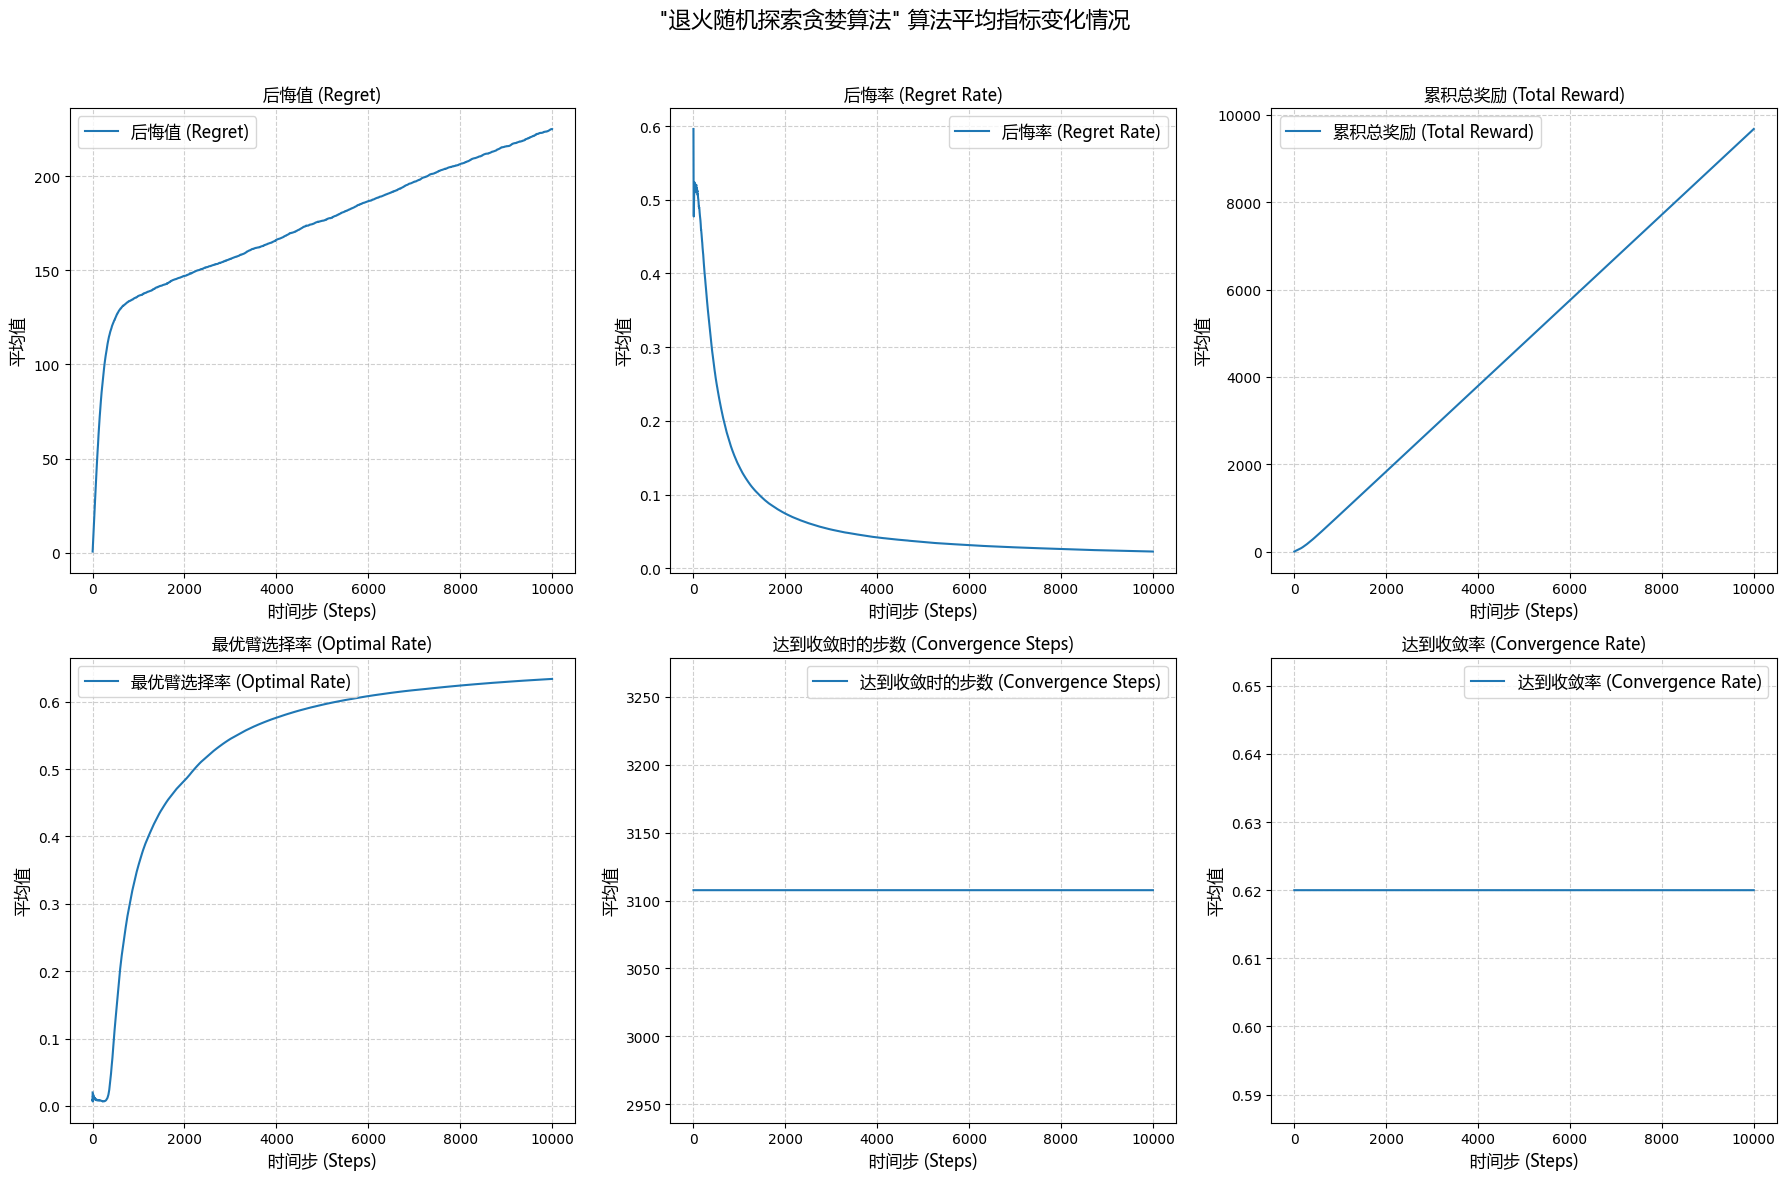

✅ 实验数据已保存至 epsilon_decreasing_average_Q_0=0.png
anget 名称: epsilon_decreasing_average
平均奖励：values=[0.0, 0.06, 0.16, 0.12, 0.12, 0.2, 0.16, 0.22, 0.26, 0.2, 0.36, 0.38, 0.48, 0.44, 0.52, 0.58, 0.6, 0.46, 0.54, 0.6, 0.68, 0.74, 0.8, 0.68, 0.86, 0.92, 0.9, 0.96, 1.02, 1.06, 1.1, 1.06, 1.14, 1.34, 1.2, 1.4, 1.28, 1.34, 1.42, 1.34, 1.24, 1.08, 1.4, 1.32, 1.46, 1.6, 1.42, 1.7, 1.86, 1.64, 1.7, 1.9, 1.9, 2.06, 2.08, 2.4, 2.28, 2.16, 2.26, 2.52, 2.38, 2.38, 2.52, 1.96, 2.82, 2.38, 2.88, 2.76, 3.06, 2.9, 3.52, 3.36, 3.8, 3.56, 3.0, 3.46, 4.82, 3.86, 3.4, 3.88, 4.24, 6.14, 5.04, 7.0, 8.24, 8.14, 6.38, 10.14, 10.66, 8.18, 7.46, 8.92, 11.9, 14.32, 140.1, 21.86, 43.2, 669.38, 2284.0, 6274.36] counts=[2.74, 3.4, 2.94, 2.98, 2.42, 2.72, 2.86, 2.76, 2.86, 2.46, 2.82, 3.04, 2.96, 3.4, 3.08, 3.18, 3.32, 2.64, 3.04, 2.8, 3.18, 2.94, 3.26, 2.7, 3.18, 3.46, 3.42, 3.3, 3.16, 3.24, 3.3, 3.16, 3.42, 3.84, 3.44, 3.96, 3.46, 3.54, 3.96, 3.66, 3.26, 3.34, 3.46, 3.28, 3.3, 3.68, 3.24, 3.76, 3.88, 3.3, 3.46, 3.82, 

22397

In [6]:
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=epsilon_decreasing_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="退火随机探索贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()